# Insuline-glucose regulatory model

Example taken from: ProbReach paper




We try to synthesize the infusion rate u and ? in order to maximize the probability that glucose rate G returns back to normal within 60 minutes after the pump started infusion.

## SOGA

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time
import matplotlib.pyplot as plt
import numpy as np
import torch

['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src']


In [2]:
from optimization import *
torch.set_default_dtype(torch.float64)

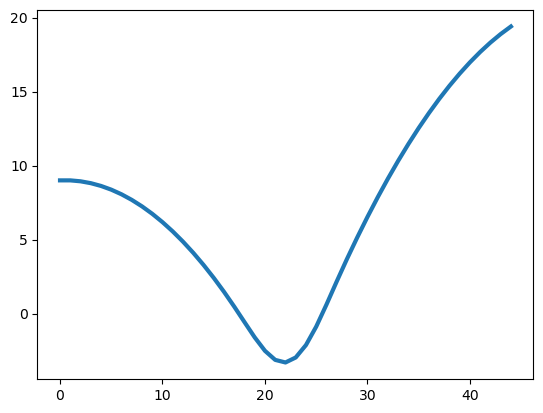

In [ ]:
soga_code = """
array[46] G;

/* Initial state */
curr_Q1 = 64.;
curr_Q2 = 40.;
dt = 0.08;            

for i in range(45) {
    /* Save current state */
    G[i] = curr_Q1 * 0.0625;

    /* Continuous dynamics */

    new_Q1 = 
    new_Q1 = new_Q1 * dt;

    if mode < 0 {
        /* falling down */
        temp = -9.8 * dt;
        newV = currV + temp + gauss(0., 0.1);
    } else {
        /* going up */
        temp = -9.8 * dt;

        spring = _R*currV;
        temp2 = _C*currH;
        spring = spring + temp2;
        spring = spring * dt; 
        spring = 0.14 * spring; 
        newV = currV + temp - spring + gauss(0., 0.1);

    } end if;

    currH = newH;
    currV = newV;

    /* Mode switching */
    if mode < 0 {
        if currH <= 0. {
            mode = 1;
            bounced = 1.;
        } else {
            skip;
        } end if;
    } else {
        if currH > 0. {
            mode = -1;
            if bounced > 0. {
                valid = count;
            } else {
                skip;
            } end if;
        } else {
            skip;
        } end if;
    } end if;
    count = count + 1.;
} end for;

/* Save final state */
H[45] = currH;

"""

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

# initialize parameters
params = {'R':  7., 'C':200.}
params_dict = initialize_params(params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

#plot
y_init = output_dist.gm.mean()[:45].detach()
plt.plot(range(45), y_init, lw=3, label='SOGA w true params')

# Points to which the lines should be drawn
#points = [(6, 20), (18, 20), (24, 20)]

# Plot the points on the graph
#for point in points:
    #plt.plot(point[0], point[1], 'ro')  # Red dot at each point
#plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

In [10]:
# find the index of the elemnet of the list output_dist.var_list corresponding to 'valid'
valid_var = [i for i, var in enumerate(output_dist.var_list) if var == 'valid']
print(int(output_dist.gm.mean()[valid_var[0]]))
print(torch.argmax(output_dist.gm.mean()[int(output_dist.gm.mean()[valid_var[0]]):45])+ int(output_dist.gm.mean()[valid_var[0]]) )

25
tensor(44)


In [11]:
# The loss maximize the probability of being > 7, having done a bounce and being in mode -1
#loss = lambda dist : - (1 - dist.gm.marg_cdf(torch.tensor([7.]), idx=int(output_dist.gm.mean()[valid_var[0]])))
#loss = lambda dist : -torch.max(torch.tensor([(1 - dist.gm.marg_cdf(torch.tensor([7.]), idx=i)) * (1 - dist.gm.marg_cdf(torch.tensor([i]), idx=valid_var[0])) for i in range(45)]) )
#loss = lambda dist : torch.argmax(dist.gm.mean()[:45])
loss = lambda dist : - (1 - dist.gm.marg_cdf(torch.tensor([20.]), idx=torch.argmax(dist.gm.mean()[int(output_dist.gm.mean()[valid_var[0]]):45]) + int(output_dist.gm.mean()[valid_var[0]])))
loss(output_dist)


tensor([[-0.4118]], grad_fn=<NegBackward0>)

R: 6.500000023679778 C: 200.49999958228204  loss: -0.4117724098089095
R: 5.999801189725794 C: 200.99998924218238  loss: -0.5250067702481179
R: 5.5008883059106575 C: 201.49812423249483  loss: -0.6353643682286655
R: 5.006774505349812 C: 201.99036198798962  loss: -0.7341945647077333
R: 4.522897765872136 C: 202.47068450373857  loss: -0.8155099464600569
R: 4.055659285157996 C: 202.93229758766967  loss: -0.8771702059880213
R: 3.610986043120701 C: 203.36924938537442  loss: -0.9206421575894589
R: 3.1931855945401146 C: 203.77755793435122  loss: -0.9495589450376396
R: 2.804559776316817 C: 204.1554330325088  loss: -0.9680380559138712
R: 2.4456571526614534 C: 204.50285428970994  loss: -0.9795889092606673
R: 2.115787862773595 C: 204.8209583796692  loss: -0.9867596192969774
R: 1.8135198504193029 C: 205.11151305577943  loss: -0.9912313942324713
R: 1.5370480739029477 C: 205.37655579883548  loss: -0.9940545534431409
R: 1.2844331426944477 C: 205.6181762243287  loss: -0.995867646113889
R: 1.0537415240818

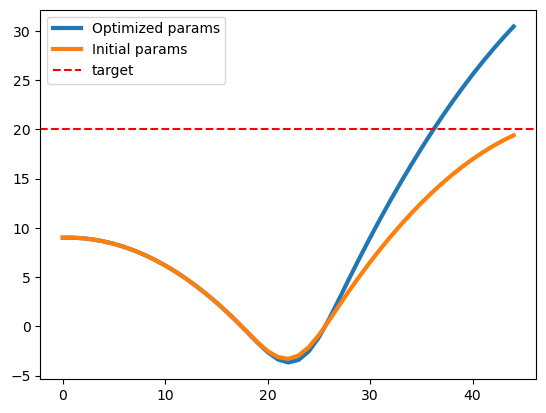

In [12]:
params_dict = initialize_params(params)
T = 45
# gradient based optimization
optimize(cfg, params_dict, loss, n_steps=20, lr=0.5)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
y_opt = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_opt, lw=3, label='Optimized params')
plt.plot(range(45), y_init, lw=3, label='Initial params')
#add horizontal line at y=20
plt.axhline(y=20, color='r', linestyle='--', label='target')
plt.legend()